<a href="https://colab.research.google.com/github/edreyesc/ProyectoFinal/blob/main/proyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Proyecto Final - Modelos Predictivos**

In [ ]:
#Carga de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)

2. Carga de Datos

In [ ]:
#Adquisición de datos
gold_price_df = pd.read_csv('https://raw.githubusercontent.com/edreyesc/ProyectoFinal/main/Gold%20Historical%20Data.csv', parse_dates=['Date'], index_col='Date', usecols=['Date', 'Price'])

#Transformación de columna numérica a float y eliminar la coma que venía del csv
gold_price_df['Price'] = gold_price_df['Price'].replace({',':''}, regex=True).astype(float)

#Impresión del dataset
gold_price_df

,Price
Date,
2024-12-31,2641.0
2024-12-30,2618.1
2024-12-27,2618.4
2024-12-26,2640.3
2024-12-24,2622.8
...,...
2014-01-08,1225.5
2014-01-07,1229.6
2014-01-06,1238.0


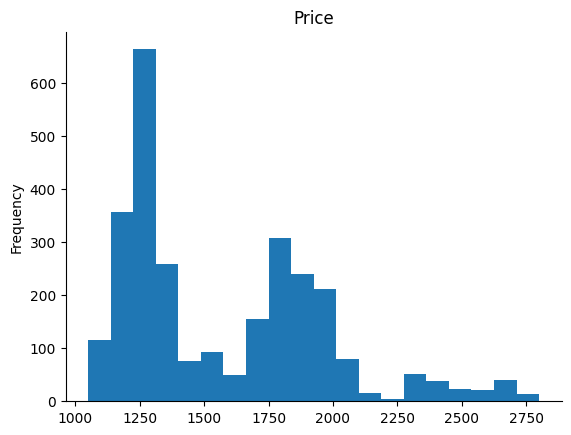

In [ ]:
# @title Price

from matplotlib import pyplot as plt
gold_price_df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

KeyError: 'Date'

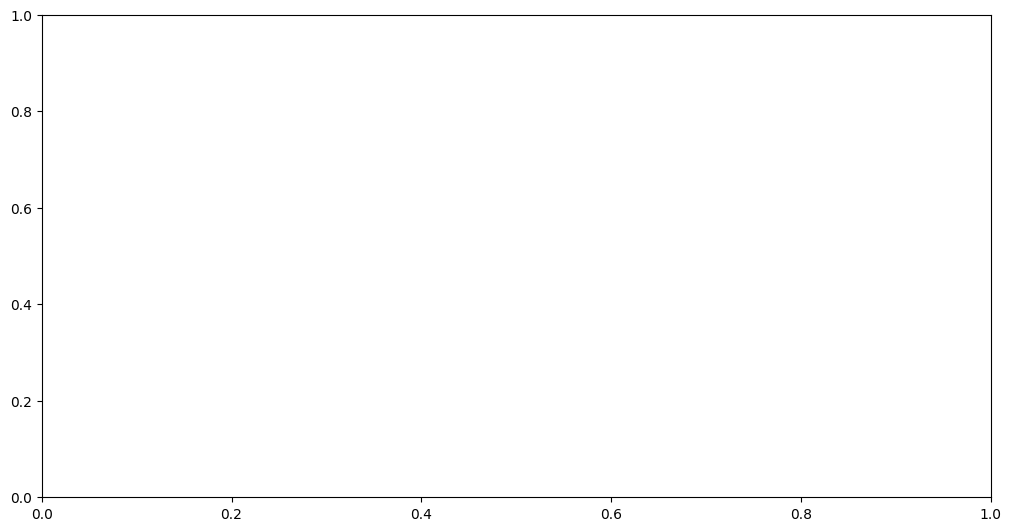

In [ ]:
# @title Date vs Price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = gold_price_df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Price')

In [ ]:
gold_price_df.isnull().sum()

,0
Price,0


In [ ]:
gold_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2816 entries, 2024-12-31 to 2014-01-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2816 non-null   float64
dtypes: float64(1)
memory usage: 44.0 KB


# **Aplicación del modelo Winters**

In [ ]:
modelo_winters = ExponentialSmoothing(
    gold_price_df['Price'],
    trend='add',
    seasonal='add',
    seasonal_periods=260
).fit()

modelo_winters.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,Price,No. Observations:,2816
Model:,ExponentialSmoothing,SSE,704257.753
Optimized:,True,AIC,16077.465
Trend:,Additive,BIC,17646.436
Seasonal:,Additive,AICC,16133.190
Seasonal Periods:,260,Date:,"Sun, 30 Mar 2025"
Box-Cox:,False,Time:,04:38:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9621726,alpha,True
smoothing_trend,0.0252838,beta,True


# **Evaluación de la calidad del ajuste**

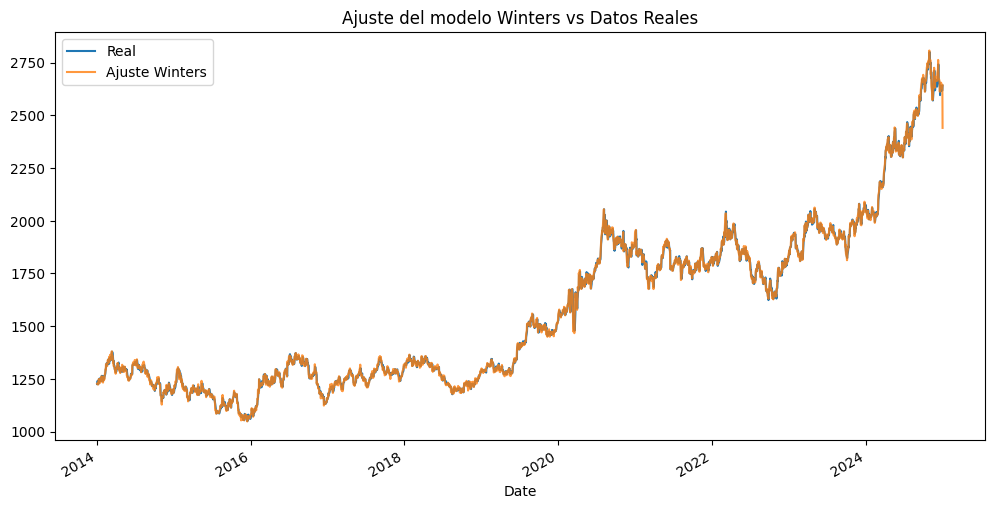

In [ ]:
# Gráfica del ajuste sobre datos reales

plt.figure(figsize=(12,6))
gold_price_df['Price'].plot(label='Real')
modelo_winters.fittedvalues.plot(label='Ajuste Winters', alpha=0.8)
plt.legend()
plt.title('Ajuste del modelo Winters vs Datos Reales')
plt.show()

# **Visualización de predicciones**

In [ ]:
prediccion = modelo_winters.forecast(12)
print(prediccion)

2816    1225.928049
2817    1222.667572
2818    1225.591261
2819    1225.189371
2820    1229.241210
2821    1231.416499
2822    1230.763554
2823    1225.718138
2824    1225.576358
2825    1223.973067
2826    1223.135176
2827    1232.815041
dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


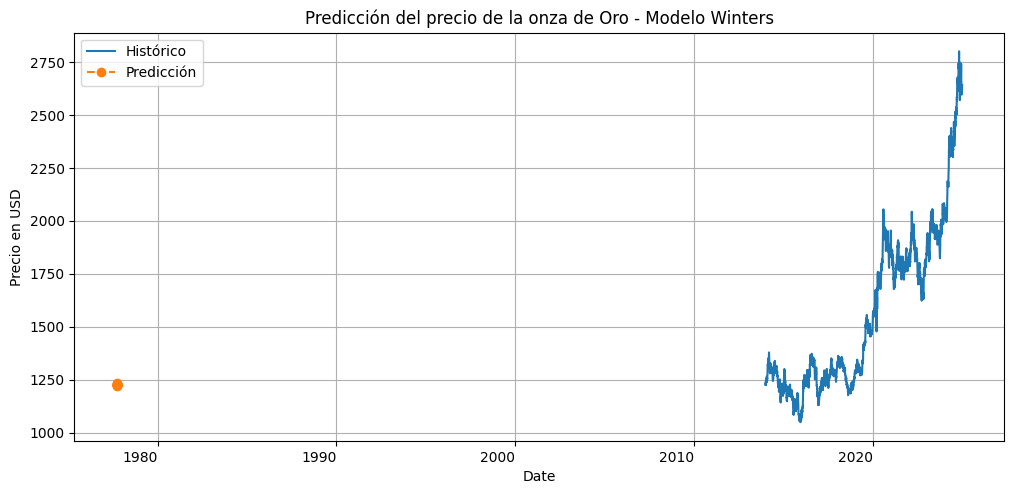

In [ ]:
# Gráfica de predicción futura
plt.figure(figsize=(12,6))
gold_price_df['Price'].plot(label='Histórico')
prediccion.plot(label='Predicción', linestyle='--', marker='o')
plt.legend()
plt.title('Predicción del precio de la onza de Oro - Modelo Winters')
plt.xlabel('Date')
plt.ylabel('Precio en USD')
plt.grid(True)
plt.show()